## Pytorch Loss Function

一般来说，监督学习的目标函数由损失函数和正则化项组成。( $ Objective = Loss + Regularization $ )

Pytorch中的损失函数一般在训练模型时候指定。

**注意Pytorch中内置的损失函数的参数和tensorflow不同，是y_pred在前，y_true在后，而Tensorflow是y_true在前，y_pred在后。**

对于**回归模型**，通常使用的内置损失函数是均方损失函数 **nn.MSELoss** 。

对于**二分类模型**，通常使用的是二元交叉熵损失函数n**n.BCELoss (输入已经是sigmoid激活函数之后的结果)**
或者**nn.BCEWithLogitsLoss (输入尚未经过nn.Sigmoid激活函数)** 。

对于**多分类模型**，一般推荐使用交叉熵损失函数**nn.CrossEntropyLoss**。
(y_true需要是一维的，是类别编码。y_pred未经过nn.Softmax激活。) 

此外，如果多分类的y_pred经过了nn.LogSoftmax激活，可以使用nn.NLLLoss损失函数(The negative log likelihood loss)。
这种方法和直接使用nn.CrossEntropyLoss等价。


如果有需要，也可以自定义损失函数，自定义损失函数需要接收两个张量y_pred，y_true作为输入参数，并输出一个标量作为损失函数值。

Pytorch中的正则化项一般通过自定义的方式和损失函数一起添加作为目标函数。

如果仅仅使用L2正则化，也可以利用优化器的weight_decay参数来实现相同的效果。

### 一、内置损失函数

In [1]:
import numpy as np
import pandas as pd
import torch 
from torch import nn 
import torch.nn.functional as F 


y_pred = torch.tensor([[10.0, 0.0, -10.0], [8.0, 8.0, 8.0]])
y_true = torch.tensor([0, 2])

# 直接调用交叉熵损失
ce = nn.CrossEntropyLoss()(y_pred,y_true)
print(ce)

# 等价于先计算nn.LogSoftmax激活，再调用NLLLoss
y_pred_logsoftmax = nn.LogSoftmax(dim = 1)(y_pred)
nll = nn.NLLLoss()(y_pred_logsoftmax, y_true)
print(nll)

tensor(0.5493)
tensor(0.5493)


内置的损失函数一般有类的实现和函数的实现两种形式。

如：nn.BCE 和 F.binary_cross_entropy 都是二元交叉熵损失函数，前者是类的实现形式，后者是函数的实现形式。

实际上类的实现形式通常是调用函数的实现形式并用nn.Module封装后得到的。

一般我们常用的是类的实现形式。它们封装在torch.nn模块下，并且类名以Loss结尾。

常用的一些内置损失函数说明如下。


* nn.MSELoss（均方误差损失，也叫做L2损失，用于回归）

* nn.L1Loss （L1损失，也叫做绝对值误差损失，用于回归）

* nn.SmoothL1Loss (平滑L1损失，当输入在-1到1之间时，平滑为L2损失，用于回归)

* nn.BCELoss (二元交叉熵，用于二分类，输入已经过nn.Sigmoid激活，对不平衡数据集可以用weigths参数调整类别权重)

* nn.BCEWithLogitsLoss (二元交叉熵，用于二分类，输入未经过nn.Sigmoid激活)

* nn.CrossEntropyLoss (交叉熵，用于多分类，要求label为稀疏编码，输入未经过nn.Softmax激活，对不平衡数据集可以用weigths参数调整类别权重)

* nn.NLLLoss (负对数似然损失，用于多分类，要求label为稀疏编码，输入经过nn.LogSoftmax激活)

* nn.CosineSimilarity(余弦相似度，可用于多分类)

* nn.AdaptiveLogSoftmaxWithLoss (一种适合非常多类别且类别分布很不均衡的损失函数，会自适应地将多个小类别合成一个cluster)


更多损失函数的介绍参考如下知乎文章：

《PyTorch的十八个损失函数》

https://zhuanlan.zhihu.com/p/61379965

### 二、自定义损失函数


自定义损失函数接收两个张量y_pred,y_true作为输入参数，并输出一个标量作为损失函数值。

也可以对nn.Module进行子类化，重写forward方法实现损失的计算逻辑，从而得到损失函数的类的实现。

下面是一个Focal Loss的自定义实现示范。Focal Loss是一种对binary_crossentropy的改进损失函数形式。

它在样本不均衡和存在较多易分类的样本时相比binary_crossentropy具有明显的优势。

它有两个可调参数，alpha参数和gamma参数。其中alpha参数主要用于衰减负样本的权重，gamma参数主要用于衰减容易训练样本的权重。

从而让模型更加聚焦在正样本和困难样本上。这就是为什么这个损失函数叫做Focal Loss。

详见《5分钟理解Focal Loss与GHM——解决样本不平衡利器》

https://zhuanlan.zhihu.com/p/80594704



$$focal\_loss(y,p) = 
\begin{cases} -\alpha (1-p)^{\gamma}\log(p) & \text{if y = 1}\\
-(1-\alpha) p^{\gamma}\log(1-p) & \text{if y = 0} 
\end{cases} $$


In [2]:
class FocalLoss(nn.Module):
    
    def __init__(self, gamma=2.0, alpha=0.75):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, y_pred, y_true):
        bce = torch.nn.BCELoss(reduction = "none")(y_pred, y_true)
        p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))
        alpha_factor = y_true * self.alpha + (1 - y_true) * (1 - self.alpha)
        modulating_factor = torch.pow(1.0 - p_t, self.gamma)
        loss = torch.mean(alpha_factor * modulating_factor * bce)
        return loss

In [3]:
#困难样本
y_pred_hard = torch.tensor([[0.5],[0.5]])
y_true_hard = torch.tensor([[1.0],[0.0]])

#容易样本
y_pred_easy = torch.tensor([[0.9],[0.1]])
y_true_easy = torch.tensor([[1.0],[0.0]])

focal_loss = FocalLoss()
bce_loss = nn.BCELoss()

print("focal_loss(hard samples):", focal_loss(y_pred_hard, y_true_hard))
print("bce_loss(hard samples):", bce_loss(y_pred_hard, y_true_hard))
print("focal_loss(easy samples):", focal_loss(y_pred_easy, y_true_easy))
print("bce_loss(easy samples):", bce_loss(y_pred_easy, y_true_easy))

#可见 focal_loss让容易样本的权重衰减到原来的 0.0005/0.1054 = 0.00474
#而让困难样本的权重只衰减到原来的 0.0866/0.6931=0.12496

# 因此相对而言，focal_loss可以衰减容易样本的权重。

focal_loss(hard samples): tensor(0.0866)
bce_loss(hard samples): tensor(0.6931)
focal_loss(easy samples): tensor(0.0005)
bce_loss(easy samples): tensor(0.1054)


FocalLoss的使用完整范例可以参考下面中`自定义L1和L2正则化项`中的范例，该范例既演示了自定义正则化项的方法，也演示了FocalLoss的使用方法。

### 三、自定义L1和L2正则化项


通常认为L1正则化可以产生稀疏权值矩阵，即产生一个稀疏模型，可以用于特征选择。

而L2正则化可以防止模型过拟合（overfitting）。一定程度上，L1也可以防止过拟合。

下面以一个二分类问题为例，演示给模型的目标函数添加自定义L1和L2正则化项的方法。

这个范例同时演示了上一个部分的FocalLoss的使用。

#### 1. 准备数据

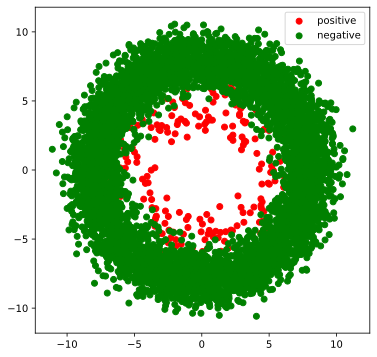

In [4]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset
import torchkeras

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#正负样本数量
n_positive, n_negative = 200, 6000

#生成正样本, 小圆环分布
r_p = 5.0 + torch.normal(0.0, 1.0, size = [n_positive, 1]) 
theta_p = 2 * np.pi * torch.rand([n_positive, 1])
Xp = torch.cat([r_p * torch.cos(theta_p), r_p * torch.sin(theta_p)], axis = 1)
Yp = torch.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + torch.normal(0.0, 1.0, size = [n_negative, 1]) 
theta_n = 2 * np.pi * torch.rand([n_negative, 1])
Xn = torch.cat([r_n * torch.cos(theta_n), r_n * torch.sin(theta_n)], axis = 1)
Yn = torch.zeros_like(r_n)

#汇总样本
X = torch.cat([Xp,Xn], axis = 0)
Y = torch.cat([Yp,Yn], axis = 0)


#可视化
plt.figure(figsize = (6, 6))
plt.scatter(Xp[:, 0], Xp[:, 1], c = "r")
plt.scatter(Xn[:, 0], Xn[:, 1], c = "g")
plt.legend(["positive", "negative"]);

In [5]:
ds = TensorDataset(X, Y)

ds_train, ds_valid = torch.utils.data.random_split(ds, [int(len(ds)*0.7), len(ds)-int(len(ds)*0.7)])
dl_train = DataLoader(ds_train, batch_size = 100, shuffle=True) # (batch_szie, 2)
dl_valid = DataLoader(ds_valid, batch_size = 100) # (batch_size, 1)

#### 2. 定义模型

In [6]:
class DNNModel(torchkeras.Model):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 8)
        self.fc3 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        y = nn.Sigmoid()(self.fc3(x))
        return y

model = DNNModel()
print(model)
model.summary(input_shape =(2, ))

DNNModel(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 4]              12
            Linear-2                    [-1, 8]              40
            Linear-3                    [-1, 1]               9
Total params: 61
Trainable params: 61
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000008
Forward/backward pass size (MB): 0.000099
Params size (MB): 0.000233
Estimated Total Size (MB): 0.000340
----------------------------------------------------------------


#### 3. 训练模型

In [7]:
# 准确率
def accuracy(y_pred,y_true):
    y_pred = torch.where(y_pred>0.5,
                         torch.ones_like(y_pred, dtype = torch.float32), 
                         torch.zeros_like(y_pred, dtype = torch.float32))
    acc = torch.mean(1-torch.abs(y_true-y_pred))
    return acc

# L2正则化
def L2Loss(model, alpha):
    l2_loss = torch.tensor(0.0, requires_grad=True)
    for name, param in model.named_parameters():
        if 'bias' not in name: #一般不对偏置项使用正则
            l2_loss = l2_loss + (0.5 * alpha * torch.sum(torch.pow(param, 2)))
    return l2_loss

# L1正则化
def L1Loss(model, beta):
    l1_loss = torch.tensor(0.0, requires_grad=True)
    for name, param in model.named_parameters():
        if 'bias' not in name:
            l1_loss = l1_loss +  beta * torch.sum(torch.abs(param))
    return l1_loss

# 将L2正则和L1正则添加到FocalLoss损失，一起作为目标函数
def focal_loss_with_regularization(y_pred, y_true):
    focal = FocalLoss()(y_pred, y_true) 
    l2_loss = L2Loss(model, 0.001) #注意设置正则化项系数
    l1_loss = L1Loss(model, 0.001)
    total_loss = focal + l2_loss + l1_loss
    return total_loss

model.compile(loss_func = focal_loss_with_regularization,
              optimizer = torch.optim.Adam(model.parameters(), lr = 0.01), 
              metrics_dict = {"accuracy":accuracy})

dfhistory = model.fit(30, dl_train=dl_train, dl_val=dl_valid, log_step_freq=30)


Start Training ...

================================================================================2021-01-31 18:12:29
{'step': 30, 'loss': 0.031, 'accuracy': 0.968}

 +-------+------+----------+----------+--------------+
| epoch | loss | accuracy | val_loss | val_accuracy |
+-------+------+----------+----------+--------------+
|   1   | 0.03 |  0.967   |  0.026   |    0.969     |
+-------+------+----------+----------+--------------+

================================================================================2021-01-31 18:12:29
{'step': 30, 'loss': 0.026, 'accuracy': 0.968}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   2   | 0.025 |  0.968   |  0.024   |    0.969     |
+-------+-------+----------+----------+--------------+

================================================================================2021-01-31 18:12:29
{'step': 30, 'loss': 0.023, 'accura

{'step': 30, 'loss': 0.018, 'accuracy': 0.983}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   22  | 0.019 |  0.981   |  0.018   |    0.982     |
+-------+-------+----------+----------+--------------+

================================================================================2021-01-31 18:12:32
{'step': 30, 'loss': 0.019, 'accuracy': 0.979}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   23  | 0.019 |   0.98   |  0.018   |    0.982     |
+-------+-------+----------+----------+--------------+

================================================================================2021-01-31 18:12:32
{'step': 30, 'loss': 0.018, 'accuracy': 0.981}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_ac

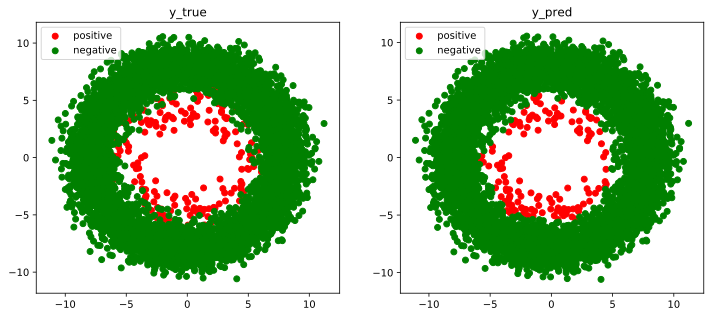

In [8]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1], c="r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = X[torch.squeeze(model.forward(X)>=0.5)]
Xn_pred = X[torch.squeeze(model.forward(X)<0.5)]

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");

#### 四、通过优化器实现L2正则化


如果仅仅需要使用L2正则化，那么也可以利用优化器的weight_decay参数来实现。

weight_decay参数可以设置参数在训练过程中的衰减，这和L2正则化的作用效果等价。


```
before L2 regularization:

gradient descent: w = w - lr * dloss_dw 

after L2 regularization:

gradient descent: w = w - lr * (dloss_dw+beta*w) = (1-lr*beta)*w - lr*dloss_dw

so （1-lr*beta）is the weight decay ratio.
```


Pytorch的优化器支持一种称之为Per-parameter options的操作，就是对每一个参数进行特定的学习率，权重衰减率指定，以满足更为细致的要求。

```python
weight_params = [param for name, param in model.named_parameters() if "bias" not in name]
bias_params = [param for name, param in model.named_parameters() if "bias" in name]

optimizer = torch.optim.SGD([{'params': weight_params, 'weight_decay':1e-5},
                             {'params': bias_params, 'weight_decay':0}],
                            lr=1e-2, momentum=0.9)

```

---

In [9]:
import torch
from torch import nn

###  Single-label categorical

In [10]:
# Single-label categorical

torch.manual_seed(0)
loss_func = nn.CrossEntropyLoss()

n = 5 # 样本数

x = torch.randn(n, 5)
yhat = torch.softmax(x, dim=-1)
y = torch.randint(3, (n, )) # 3个标签

loss = loss_func(yhat, y)

print(x)
print(yhat)
print(y)
print(loss.item())

tensor([[-1.1258, -1.1524, -0.2506, -0.4339,  0.8487],
        [ 0.6920, -0.3160, -2.1152,  0.3223, -0.1577],
        [ 1.4437,  0.2660,  0.1665,  0.8744, -0.1435],
        [-0.1116, -0.6136,  1.2590,  2.0050,  0.0537],
        [ 0.6181, -0.4128, -0.8411, -2.3160, -0.1023]])
tensor([[0.0737, 0.0717, 0.1768, 0.1472, 0.5307],
        [0.3931, 0.1435, 0.0237, 0.2716, 0.1681],
        [0.4242, 0.1307, 0.1183, 0.2401, 0.0868],
        [0.0666, 0.0403, 0.2621, 0.5526, 0.0785],
        [0.4697, 0.1676, 0.1092, 0.0250, 0.2286]])
tensor([0, 1, 1, 1, 2])
1.7225539684295654


###  Multi-label categorical

In [11]:
# Multi-label categorical
# BCELoss all elements of input should be between 0 and 1, so activation function must be sigmoid?(tanh relu都不行)

torch.manual_seed(0)
loss_func = nn.BCELoss()

n = 1
x = torch.randn(n, 5)
yhat = torch.sigmoid(x)
y = torch.randint(2, (n, 5), dtype=torch.float32)

loss = loss_func(yhat, y)

print(x)
print(yhat)
print(y)
print(loss.item())

tensor([[ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845]])
tensor([[0.8236, 0.4272, 0.1017, 0.6384, 0.2527]])
tensor([[0., 1., 0., 0., 0.]])
0.8002605438232422


In [12]:
# sigmoid or softmax??

torch.manual_seed(0)
loss_func = nn.BCELoss()

n = 1
x = torch.randn(n, 5)
yhat = nn.Softmax(dim=-1)(x)
y = torch.randint(2, (n, 5), dtype=torch.float32)

loss = loss_func(yhat, y)

print(x)
print(yhat)
print(y)
print(loss.item())

tensor([[ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845]])
tensor([[0.6118, 0.0977, 0.0148, 0.2313, 0.0443]])
tensor([[0., 1., 0., 0., 0.]])
0.7190769910812378


In [13]:
loss_func = nn.BCELoss()
y_pred = torch.tensor([[0.05, 0.95, 0], [0.1, 0.8, 0.1]], dtype=torch.float32)
y_true = torch.tensor([[0.0, 1.0, 0.0], [0.0, 0.0, 1.0]], dtype=torch.float32)
loss = loss_func(y_pred, y_true)
print(y_pred)
print(y_true)
print(loss.item()) # 0.034195, 1.339127898

tensor([[0.0500, 0.9500, 0.0000],
        [0.1000, 0.8000, 0.1000]])
tensor([[0., 1., 0.],
        [0., 0., 1.]])
0.6866617202758789


#### in tensorflow：

In [14]:
import numpy as np
import tensorflow as tf
tf.enable_eager_execution()

y_pred = np.array([[0.05, 0.95, 0], [0.1, 0.8, 0.1]])
y_true = np.array([[0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
assert loss.shape == (2, )
loss.numpy()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

array([0.05129329, 2.30258509])

#### 如果是稀疏tensor，维度越大，loss就会越小

In [15]:
loss_func = nn.BCELoss()
y_pred = torch.tensor([[0.05, 0.95, 0,0,0,0,0,0,0,0,0,0,0,0,0]], dtype=torch.float32)
y_true = torch.tensor([[0, 0, 1,0,0,0,0,0,0,0,0,0,0,0,0]], dtype=torch.float32)
loss = loss_func(y_pred, y_true)
print(y_pred)
print(y_true)
print(loss.item())

tensor([[0.0500, 0.9500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
6.869801998138428
